<a href="https://colab.research.google.com/github/BrunoEMendes/Google_colab_NN/blob/master/GruPredictTemp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GRU PREDICT TEMPERATURE

Data extracted from "https://climateknowledgeportal.worldbank.org/download-data"

Dataset structure : [year month Rainfall Temperature]


In [257]:
import datetime
import tensorflow as tf
import numpy as np
import pandas as pd

## Reading Data

In [258]:
from pandas import read_csv

file_url = "https://raw.githubusercontent.com/BrunoEMendes/Google_colab_NN/master/weather_predict/input/temp-rain.csv"
dataset = read_csv(file_url)
print(dataset[:12])

     Year  Month   Rainfall  Temperature
0    1901      1   95.41630      7.87119
1    1901      2   94.85550      6.38664
2    1901      3  167.21800      9.50226
3    1901      4   56.53060     13.22100
4    1901      5   41.43890     15.69000
5    1901      6   11.08040     19.98460
6    1901      7    5.27905     21.56480
7    1901      8    4.28003     22.13090
8    1901      9   99.67530     18.29120
9    1901     10   79.87950     13.71970
10   1901     11   71.79130      9.62800
11   1901     12  100.22600      6.79127


Get temp and rainfall cols only


In [259]:
df = dataset.dropna()
df = df[['Temperature']]
print(df[:12])

    Temperature
0       7.87119
1       6.38664
2       9.50226
3      13.22100
4      15.69000
5      19.98460
6      21.56480
7      22.13090
8      18.29120
9      13.71970
10      9.62800
11      6.79127


In [260]:
 print(df.describe())

       Temperature
count  1392.000000
mean     14.725823
std       5.036300
min       5.460670
25%      10.217500
50%      14.118400
75%      19.695425
max      24.551800


In [261]:
import matplotlib.pyplot as plt
#plt.figure(1, figsize =(16, 6))
#plt.plot(df.Rainfall)
#plt.xlabel('month')
#plt.ylabel('rainfall')
#plt.show()

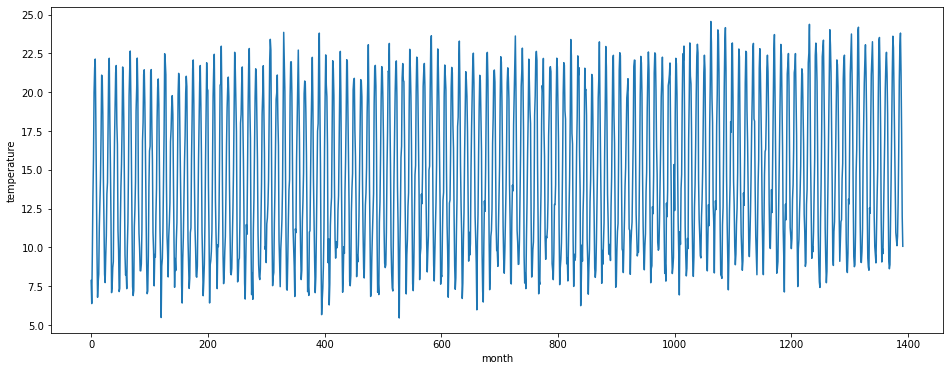

In [262]:
plt.figure(1, figsize =(16, 6))
plt.plot(df.Temperature)
plt.xlabel('month')
plt.ylabel('temperature')
plt.show()

## Data Normalization

Normalize the data between -1, 1

In [263]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler(feature_range = (-1, 1))
X = min_max_scaler.fit_transform(df.values)
print(X[:12])
print('---')
print('X data shape: ', X.shape)

[[-0.74747226]
 [-0.90299474]
 [-0.57660023]
 [-0.18702245]
 [ 0.07163169]
 [ 0.52153697]
 [ 0.68707981]
 [ 0.74638484]
 [ 0.34413521]
 [-0.1347783 ]
 [-0.56342762]
 [-0.86060542]]
---
X data shape:  (1392, 1)


We are trying to forecast the temperatures for years to come, therefore our target(y) will correspond to the temperatures

## Train/Test split

In [264]:
y = X[:, 0]
print(y)
print('---')
print(y.shape)

[-0.74747226 -0.90299474 -0.57660023 ...  0.24248591 -0.31417051
 -0.51648436]
---
(1392,)


Split data
Test data = 20%

In [265]:
from sklearn.model_selection import train_test_split
test_size_var = 0.20
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = test_size_var, random_state = 42)
print('X train shape: ', Xtrain.shape)
print('Y train shape: ', ytrain.shape)
print('X test shape: ', Xtest.shape)
print('Y test shape: ', ytest.shape)

X train shape:  (1113, 1)
Y train shape:  (1113,)
X test shape:  (279, 1)
Y test shape:  (279,)


## Build Train/Test Time Steps

To predict $t + 1$ into the future we will check $n_{time\_steps}$ in the past

In [266]:
time_steps = 12

def get_data_time_steps(X, y, time_steps = 3):

    Xres = []
    yres = []

    for i in range(time_steps, len(X)):
        Xres.append(X[i - time_steps: i, : X.shape[1]])
        yres.append(y[i])

    return np.array(Xres), np.array(yres)

X_train, y_train = get_data_time_steps(Xtrain, ytrain, time_steps)
X_test, y_test = get_data_time_steps(Xtest, ytest, time_steps)

print('X train shape: ', X_train.shape)
print('Y train shape: ', y_train.shape)
print('X test shape: ', X_test.shape)
print('Y test shape: ', y_test.shape)


X train shape:  (1101, 12, 1)
Y train shape:  (1101,)
X test shape:  (267, 12, 1)
Y test shape:  (267,)


## Gated Recurrent Unit Neural Network Model


Because we now have the data, we can build our GRU model

In [267]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.recurrent import GRU

model = Sequential()
model.add(GRU(128, input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

print(model.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_9 (GRU)                  (None, 128)               50304     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 129       
Total params: 50,433
Trainable params: 50,433
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model.fit(X_train, y_train, batch_size=16, epochs=1000)

### Ploting last 100 predictions



Evaluate train dada
35/35 [==============================] - 0s 4ms/step - loss: 1.3817e-04
0.00013816556020174176
---
Evaluate test dada
9/9 [==============================] - 0s 4ms/step - loss: 0.3909
0.390941321849823
---
9/9 [==============================] - 0s 4ms/step


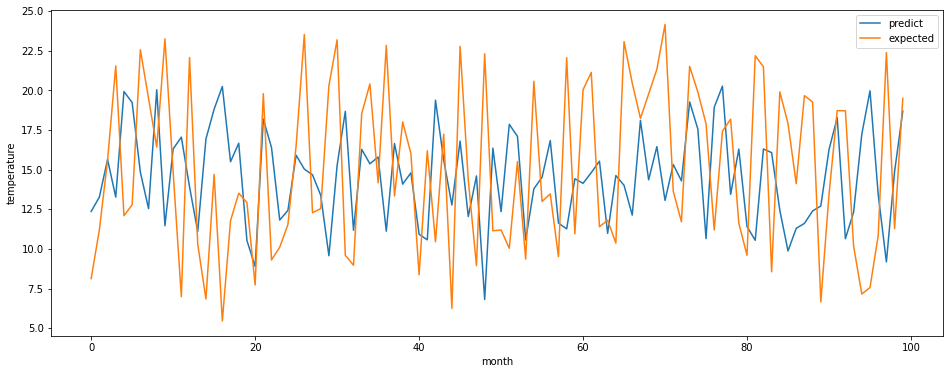

In [274]:

def inverse_scaling(y_inverted):
  y_inverted = np.c_[y_inverted, np.zeros(y_inverted.shape)]
  return min_max_scaler.inverse_transform(y_inverted)[:, 0]

print('Evaluate train dada')
print(model.evaluate(X_train, y_train))
print('---')
print('Evaluate test dada')
print(model.evaluate(X_test, y_test))
print('---')
y_predict = model.predict(X_test, verbose = 1)
y_predict_inverted = inverse_scaling(y_predict)[len(y_predict) - 100:]
y_test_inverted = inverse_scaling(y_test)[len(y_predict) - 100:]

plt.figure(1, figsize =(16, 6))
pred_plot,  = plt.plot(range(0, len(y_predict_inverted)), y_predict_inverted, label = 'predict')
expec_plot,  = plt.plot(range(0, len(y_test_inverted)), y_test_inverted, label = 'expected')
plt.legend(handles=[pred_plot, expec_plot])
plt.xlabel('month')
plt.ylabel('temperature')
plt.show()




## Predict Future

We will try now using the data from $Xtrain$ to predict the $ytest$ step by step.

So if we use the last $time\_steps$ values of $Xtrain$, we should be abble to predict the first value of $ytest$ 

In [275]:

X_future = []
for i in range(Xtrain.shape[0], Xtrain.shape[0] + 1):
  X_future.append(Xtrain[i - time_steps: i, :])

X_future = np.array(X_future)
y_future = model.predict(X_future)
y_future_inversed = inverse_scaling(y_future)
print('Next month temperature: ', y_future_inversed)
print('Expected :', inverse_scaling(y_test[0]))

Next month temperature:  [14.22237168]
Expected : [7.63719]


### Predict multiple steps into the future


For each month that we predict, we will train the Neural Network with the values obtained and compare to the test data, which should be in fact named valid data for this.

First we will be creating a deep clone of our GRU model

In [277]:
from keras.models import clone_model

# creating a model copy so we dont destroy our model
model_copy = clone_model(model)

# because the cloen doesnt copy the weights, optimizer and loss function we have to set them up
model_copy.compile(loss='mse', optimizer='adam')
model_copy.set_weights(model.get_weights())

# assert if copy is the equal to the model
assert model_copy.evaluate(X_train, y_train) == model.evaluate(X_train, y_train)

print('---')
print(model_copy.summary())
print('---')


35/35 [==============================] - 0s 4ms/step - loss: 1.3817e-04
---
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_9 (GRU)                  (None, 128)               50304     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 129       
Total params: 50,433
Trainable params: 50,433
Non-trainable params: 0
_________________________________________________________________
None
---


Each Step we predict the next values using the values that we generated on the previous step

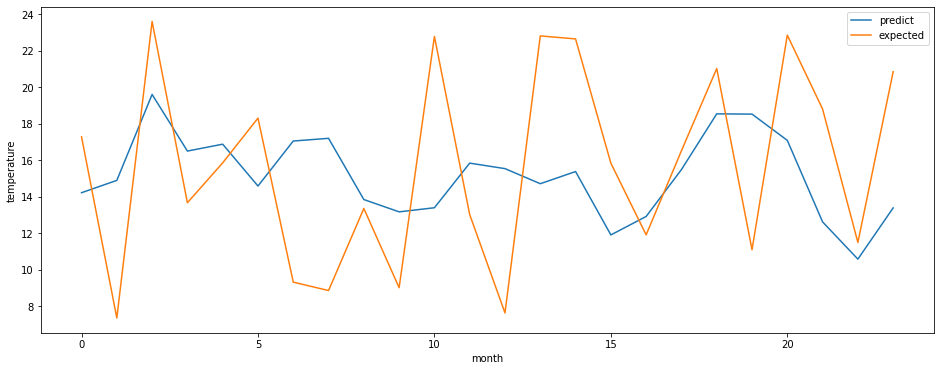

In [272]:
n_months_predict = 24

# generates the next predict set
def generate_future_predict_time_series(Xtrain):
  X_future = []
  for i in range(Xtrain.shape[0], Xtrain.shape[0] + 1):
    X_future.append(Xtrain[i - time_steps: i, :])
  return np.array(X_future)

# we will have to update the train data atleast for time_series times so we can get the last time series values
X_future_train_data = Xtrain

# loop n_months times
for i in range(n_months_predict):
  
  # get future predict
  X_future_pred = generate_future_predict_time_series(X_future_train_data)
  # predict model
  y_future_pred = model_copy.predict(X_future_pred)
  #print(f'month: {len(ytrain)+i} predicted {inverse_scaling(y_future_pred)}')

  # train with new values
  #model_copy.fit(X_future_pred, y_future_pred, epochs=1, batch_size=1)
  
  # update X_future_train_data,
  X_future_train_data = np.concatenate((X_future_train_data, y_future_pred))

#print(inverse_scaling(X_future_train_data[len(Xtrain):]))
#print(inverse_scaling(ytest[:n_months_predict]))

plt.figure(1, figsize =(16, 6))
pred_plot,  = plt.plot(range(0, n_months_predict), inverse_scaling(X_future_train_data[len(Xtrain):]), label = 'predict')
expec_plot,  = plt.plot(range(0, n_months_predict), inverse_scaling(ytest[:n_months_predict]), label = 'expected')
plt.legend(handles=[pred_plot, expec_plot])
plt.xlabel('month')
plt.ylabel('temperature')
plt.show()



Ploting real data + prediction

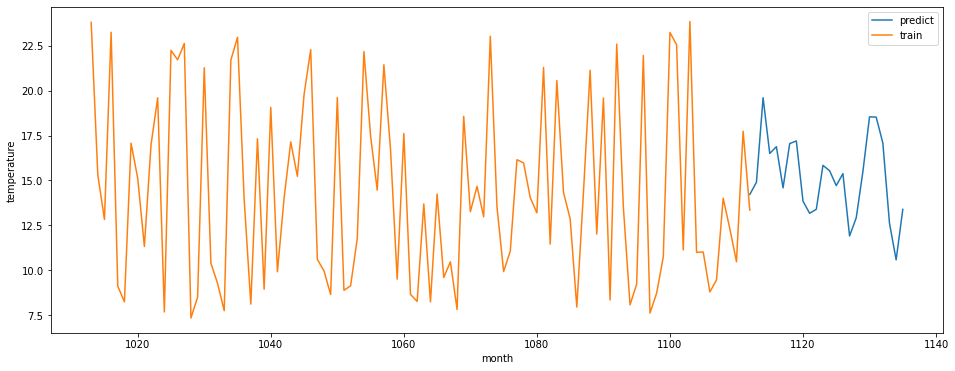

In [273]:
plt.figure(1, figsize =(16, 6))
pred_plot,  = plt.plot(range(len(Xtrain) - 1, len(Xtrain) + n_months_predict - 1), inverse_scaling(X_future_train_data[len(Xtrain):]), label = 'predict')
expec_plot,  = plt.plot(range(len(Xtrain) - 100, len(Xtrain)), inverse_scaling(Xtrain[len(Xtrain) - 100:]), label = 'train')
plt.legend(handles=[pred_plot, expec_plot])
plt.xlabel('month')
plt.ylabel('temperature')
plt.show()